# Final Project Presentation - Charles Griego
## Exploring NSF Graduate Research Fellowship Recipients

<table><tr><td><img src="nsf-logo.png" alt="Drawing" style="width: 500px;"></td><td><img src="GRFP_logo.png" alt="Drawing" style="width: 500px;"></td></tr></table>

### Introduction

- NSF awards annually about 2000 fellowships through the Graduate Research Fellowships Program (GRFP). 

- This award gives graduate students financial support and freedom to choose a graduate program and research lab. 

- The award boost careers and eases pressure on faculty to raise funding to support graduate students. 

- Studies suggest that this award disproportionally goes to students at top schools because [they encourage more students to apply.](https://www.sciencemag.org/careers/2019/08/nsf-graduate-fellowships-disproportionately-go-students-few-top-schools)

- I chose to investigate how awards are distributed among universities from the last ten years (2011-2020). 

### Tasks

- Building the DataFrame

- Formatting institution names

### Analysis

- Which institutions see the most NSF GRFP recipients

- What percentage of NSF GRFP recipients do universities receive

### Methods

- NSF provides accessible lists of award winners and honorable mentions for [each year.](https://www.research.gov/grfp/AwardeeList.do?method=loadAwardeeList)
- These lists are exportable as CSV files

<img src="fastlane_screenshot.png" alt="Drawing" style="width: 1500px;">

In [1]:
import pandas as pd

### Building the DataFrame
Below is a function that reads the CSV files using the `read_csv()` function. The names of the recipients aren't included so that the dataset is anonymous.

In [2]:
import numpy as np
years = [str(int(y)) for y in np.linspace(2011,2020,10)]

def read_data(years, status):
    
    dflist = []
    for year in years:
        df1 = pd.read_csv(f'{year}{status}.csv',
                         index_col=None,
                         header=0,
                         encoding='latin-1')
        
        df2 = pd.DataFrame({'Baccalaureate Institution':df1['Baccalaureate Institution'],
                            'Current Institution':df1['Current Institution'],
                            'Field of Study':df1['Field of Study'],
                            'Year':[year]*len(df1),
                            'Status':[status]*len(df1)})

        dflist.append(df2)

    df_all = pd.concat(dflist, axis=0, ignore_index=True)
    
    return df_all

Here we use the function `read_data()` that was defined above to make a dataframe of award winners.

In [3]:
awards = read_data(years, 'award')
mentions = read_data(years, 'mention')
nsf = pd.concat([awards, mentions], axis=0, ignore_index=True)

In [4]:
nsf.head()

,Baccalaureate Institution,Current Institution,Field of Study,Year,Status
0,University of Minnesota-Twin Cities,University of Minnesota-Twin Cities,Chemistry - Analytical,2011,award
1,University of Southern Mississippi,University of Southern Mississippi,Chemistry - Polymer,2011,award
2,University of New Mexico,University of Washington,Life Sciences - Molecular Biology,2011,award
3,University of Texas at Austin,UNIVERSITY OF CALIFORNIA BERKELEY,Life Sciences - Developmental Biology,2011,award
4,Vanderbilt University,Vanderbilt University,Life Sciences - Biophysics,2011,award


The `Current Institution` column contains NaN values. These values are changed to 'Undecided.'

In [5]:
nsf = nsf.fillna({'Current Institution':'Undecided'})
nsf.isna().any()

Baccalaureate Institution    False
Current Institution          False
Field of Study               False
Year                         False
Status                       False
dtype: bool

### Formatting institution names

- Information like institution names were typed directly by the applicant

- There are inconsistencies in the ways that institution names are recorded 

    - Varying abbreviations
    - Different letter casing
    - Use of symbols
    - Typos 

- Here, inistitution names are formatted to match names from an external list, so that entries can be grouped together by university name as accurately as possible.

### Removing capital letters

Here we find that these entries are case sensitive, making the number of unique institutions larger than it actually is.

In [6]:
print('Unique entries with no change:',len(nsf['Baccalaureate Institution'].unique()))
print('Unique entries with all lower case:',len(nsf['Baccalaureate Institution'].str.lower().unique()))

nsf[['Baccalaureate Institution','Current Institution']] = (nsf[['Baccalaureate Institution',
                                                                 'Current Institution']]
                                                            .apply(lambda x: x.str.lower()))

Unique entries with no change: 1530
Unique entries with all lower case: 1484


Next, we use `.translate()` to remove any punctuation marks that may be in an entry. We use a library of punctuation marks from the `string` module.

In [7]:
import string

def remove_punctuation(x):
    return x.str.translate({ord(c): None for c in string.punctuation})

nsf[['Baccalaureate Institution','Current Institution']] = (nsf[['Baccalaureate Institution',
                                                            'Current Institution']]
                                                            .apply(remove_punctuation, axis=1))

print('Unique entries with punctuation removed:', len(nsf['Baccalaureate Institution'].unique()))

Unique entries with punctuation removed: 1457


### Comparing names to an external list

Now, we can cross-reference our data to an exisitng source. A JSON file of all world university names and domains was obtained from [this Github repository.](https://github.com/Hipo/university-domains-list)

In [8]:
unis = pd.read_json('world_universities_and_domains.json')
usa_unis = unis[unis['country'] == 'United States']
usa_unis.head()

,alpha_two_code,country,domains,name,state-province,web_pages
0,PA,United States,[marywood.edu],Marywood University,None,[http://www.marywood.edu]
2,US,United States,[lindenwood.edu],Lindenwood University,None,[http://www.lindenwood.edu/]
5,US,United States,[sullivan.edu],Sullivan University,None,[https://sullivan.edu/]
6,US,United States,[fscj.edu],Florida State College at Jacksonville,None,[https://www.fscj.edu/]
7,US,United States,[xavier.edu],Xavier University,None,[https://www.xavier.edu/]


In [9]:
usa_unis['name'] = usa_unis['name'].str.lower().apply(lambda x: x.translate({ord(c): None for c in string.punctuation}))
usa_unis = usa_unis['name'].sort_values().unique()

C:\Users\chas0\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


The `find_in_uni_list()` function checks if a supplied name is in the `usa_unis` list.

In [10]:
def find_in_uni_list(x, uni_list):
    check = 0
    for u_name in uni_list:
         if x == u_name:
            check = 1
    return check

The `check_similar` function is intended for names that don't have a direct match in `usa_unis`. Here the function will match string similarities and supply a percentage of similarity.

In [11]:
from fuzzywuzzy import fuzz

def check_similar(x, uni_list, tolerance):
    check = 0
    name = None
    for u_name in uni_list:
        if fuzz.token_set_ratio(x, u_name) >= tolerance:
            check = 1
            name = u_name
    return name, check

Finally, `clean_names` puts the two above functions together.

In [12]:
def clean_names(nsf, nsf_column_name, usa_unis):
    
    nsf_group = nsf.groupby([nsf_column_name])
    
    for nsf_name, group in nsf_group:
        
        if find_in_uni_list(nsf_name,usa_unis) != 1:
            
            u_name, check = check_similar(nsf_name, usa_unis, 95)
            
            if check == 1:
                
                nsf.loc[nsf_group.groups[nsf_name].values, nsf_column_name] = (
                    nsf.loc[nsf_group.groups[nsf_name].values, nsf_column_name]
                    .apply(lambda x: u_name))
                
    return nsf

In [13]:
nsf = clean_names(nsf, 'Baccalaureate Institution', usa_unis)
nsf = clean_names(nsf, 'Current Institution', usa_unis)

### Counting occurences of recipients for each university

Below we use `.value_counts()` to count how many times a name of a university shows up in `Baccalaureate Institution` and `Current Institution`.

In [14]:
bacc_counts = nsf['Baccalaureate Institution'].value_counts()
bacc_counts = pd.DataFrame(data=bacc_counts).rename(columns={'Baccalaureate Institution' : 'Counts'})

curr_counts = nsf['Current Institution'].value_counts()
curr_counts = pd.DataFrame(data=curr_counts).rename(columns={'Current Institution' : 'Counts'})

Below is a function that adds a column for `award` and `mention`.

In [15]:
def recipient_counts(df, column):
    for i,n in df.iterrows():
        ac = nsf[nsf[column] == i]['Status'].value_counts()
        for j, a in ac.items():
            df.loc[i,j] = a
            
    df = df.fillna(0)
    return df

In [16]:
bacc_counts = recipient_counts(bacc_counts, 'Baccalaureate Institution')
curr_counts = recipient_counts(curr_counts, 'Current Institution')
curr_counts.head()

,Counts,award,mention
undecided,3192,1886.0,1306.0
stanford university,1570,936.0,634.0
massachusetts institute of technology,1203,755.0,448.0
university of california berkeley,1114,623.0,491.0
university of washington,1011,508.0,503.0


### Results and Discussion

### Which institutions see the most NSF GRFP recipients?

First we investigate the top ten baccalaureate institutions to produce the most recipients (award winners and honorable mentions) in the past ten years.

### Baccalaureate Institutions

<IPython.core.display.Javascript object>


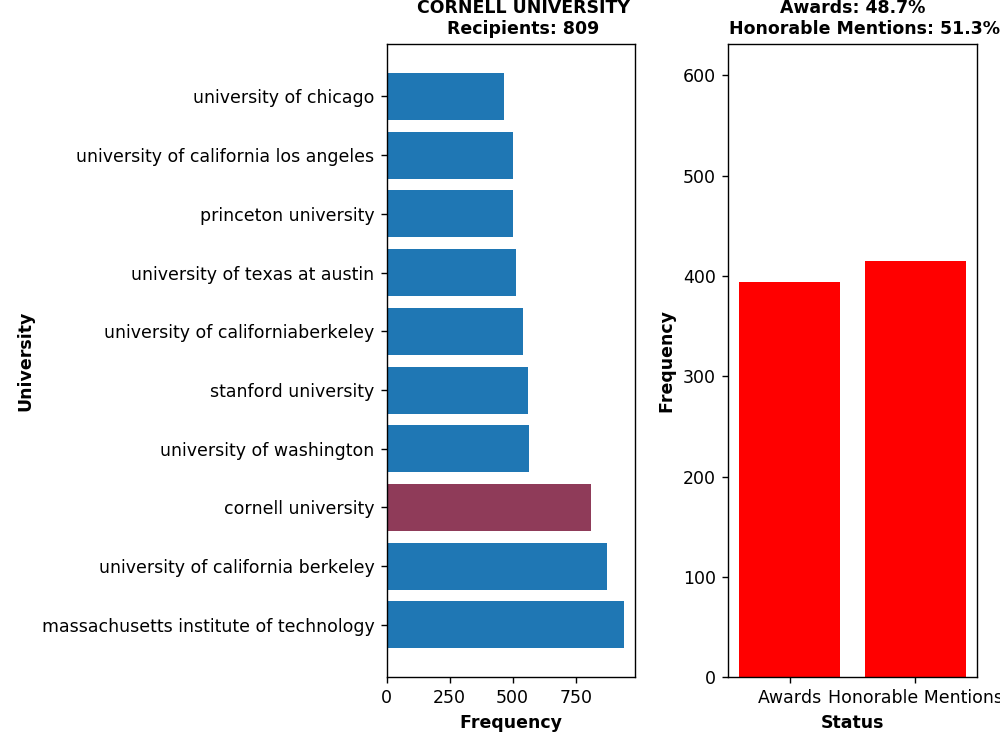

In [21]:
%matplotlib notebook
import matplotlib.pyplot as plt

tol = 465
df_plot = bacc_counts[bacc_counts['Counts'] > tol]
df_x = df_plot.index
df_y = df_plot['Counts']
df_y2 = df_plot['award']
df_y3 = df_plot['mention']

fig, (ax0, ax1) = plt.subplots(1, 2,figsize=(8,6))

ax0.barh(y=df_x, width=df_y, picker=True)
ax0.set_ylabel('University',{'fontsize':10, 'fontweight':'bold'})
ax0.set_xlabel('Frequency',{'fontsize':10, 'fontweight':'bold'})
ax0.set_title('Click on a bar',
             {'fontsize':12, 'fontweight':'bold'})

ax1.set_xlabel('Status',{'fontsize':10, 'fontweight':'bold'})
ax1.set_ylabel('Frequency',{'fontsize':10, 'fontweight':'bold'})
ax1.set_title('Click on a bar',
             {'fontsize':12, 'fontweight':'bold'})

marker0, = ax0.barh(y=df_x[0], width=df_y[0],color='r',alpha=0.5,visible=False)
marker1, = ax1.bar('Awards', df_y2[0],color='r',visible=False)
marker2, = ax1.bar('Honorable Mentions', df_y3[0],color='r',visible=False)

def onpick(event):
    
    art = event.artist
    uni_name = df_plot[df_plot["Counts"] == art.get_width()].index[0]
    
    ax0.set_title(f'''
    {uni_name.upper()}
    Recipients: {int(art.get_width())}''',
    {'fontsize':10, 'fontweight':'bold'})
                 
    marker0.set_visible(True)
    marker0.set_xy(art.xy)
    marker0.set_width(art.get_width())
    
    ax1.set_title(f'''Awards: {np.round(100* (df_y2[uni_name] / art.get_width()),2)}%
    Honorable Mentions: {np.round(100* (df_y3[uni_name] / art.get_width()),2)}%''',
    {'fontsize':10, 'fontweight':'bold'})
    
    marker1.set_visible(True)
    marker1.set_height(df_y2[uni_name])
    
    marker2.set_visible(True)
    marker2.set_height(df_y3[uni_name])
    
    fig.canvas.draw()

fig.canvas.mpl_connect('pick_event', onpick)
plt.tight_layout()
plt.show()

The top three universities that produce NSF GRFP recipients: 
- Cornell University
- University of California Berkeley
- Massachusetts Institute of Technology

### Current Institutions

<IPython.core.display.Javascript object>


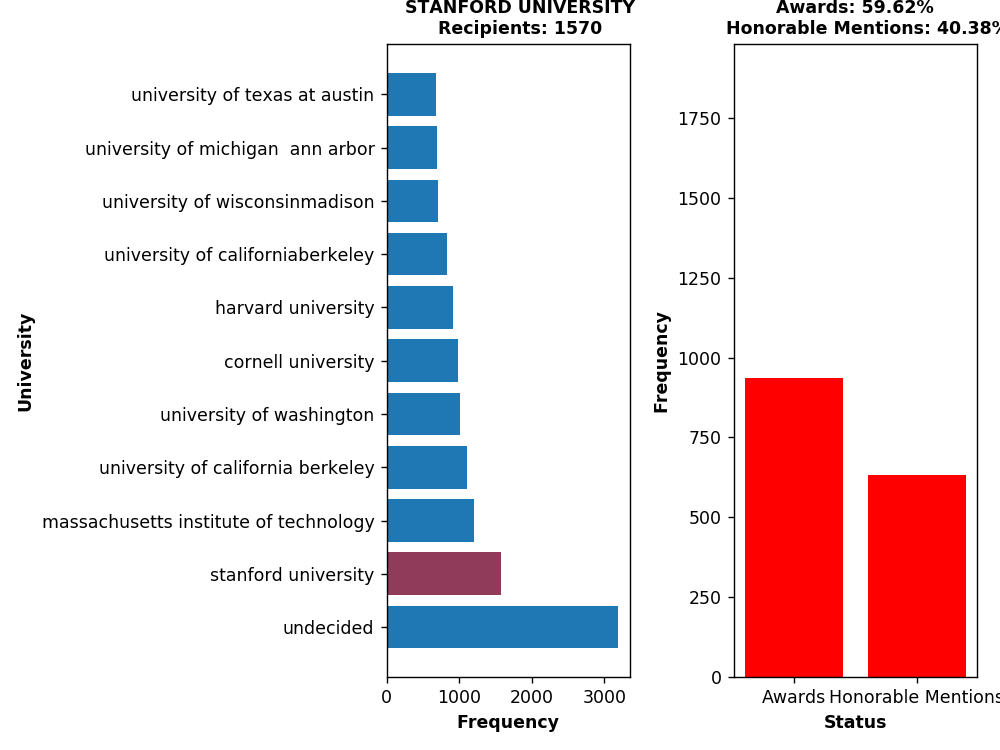

In [22]:
%matplotlib notebook
import matplotlib.pyplot as plt

tol = 650
df_plot = curr_counts[curr_counts['Counts'] > tol]
df_x = df_plot.index
df_y = df_plot['Counts']
df_y2 = df_plot['award']
df_y3 = df_plot['mention']

fig, (ax0, ax1) = plt.subplots(1, 2,figsize=(8,6))

ax0.barh(y=df_x, width=df_y, picker=True)
ax0.set_ylabel('University',{'fontsize':10, 'fontweight':'bold'})
ax0.set_xlabel('Frequency',{'fontsize':10, 'fontweight':'bold'})
ax0.set_title('Click on a bar',
             {'fontsize':12, 'fontweight':'bold'})

ax1.set_xlabel('Status',{'fontsize':10, 'fontweight':'bold'})
ax1.set_ylabel('Frequency',{'fontsize':10, 'fontweight':'bold'})
ax1.set_title('Click on a bar',
             {'fontsize':12, 'fontweight':'bold'})

marker0, = ax0.barh(y=df_x[0], width=df_y[0],color='r',alpha=0.5,visible=False)
marker1, = ax1.bar('Awards', df_y2[0],color='r',visible=False)
marker2, = ax1.bar('Honorable Mentions', df_y3[0],color='r',visible=False)

fig.canvas.mpl_connect('pick_event', onpick)
plt.tight_layout()
plt.show()

Many of these applicants were undergraduates that, at the time of the application, *may not have even known which schools they would apply to for graduate school.* Therefore, the current institution wasn't recorded. We label these cases as "undecided" current institutions.

Top three universities that received NSF GRFP recipients:
- UC Berkeley
- MIT
- Stanford

### What percentage of NSF GRFP recipients do universities receive?

<IPython.core.display.Javascript object>


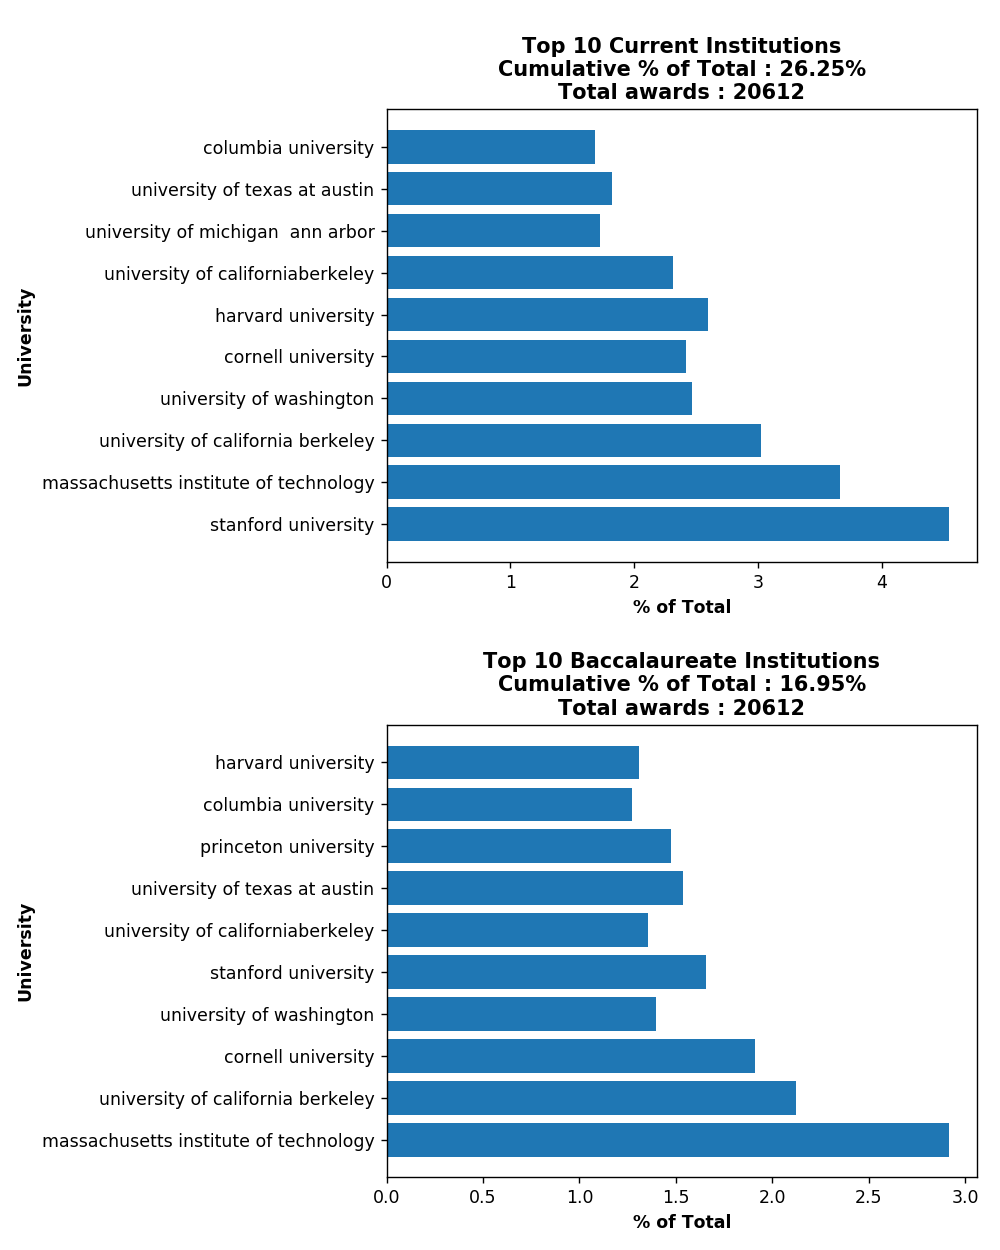

In [19]:
%matplotlib notebook
import matplotlib.pyplot as plt

tol = 340

total = curr_counts.award.sum()
df_plot = curr_counts[curr_counts['award'] > tol]['award'].apply(lambda x: 100 * (x / total))
df_plot = df_plot.drop('undecided')
df_x = df_plot.index
df_y = df_plot.values

fig, (ax0, ax1) = plt.subplots(2, 1,figsize=(8,10))

ax0.barh(y=df_x, width=df_y)
ax0.set_ylabel('University',{'fontsize':10, 'fontweight':'bold'})
ax0.set_xlabel('% of Total',{'fontsize':10, 'fontweight':'bold'})
ax0.set_title(f'''
Top 10 Current Institutions
Cumulative % of Total : {np.round(df_plot.sum(),2)}%
Total awards : {int(total)}''',
             {'fontsize':12, 'fontweight':'bold'})

tol2 = 260

total2 = bacc_counts.award.sum()
df_plot2 = bacc_counts[bacc_counts['award'] > tol2]['award'].apply(lambda x: 100 * (x / total2))
df_x2 = df_plot2.index
df_y2 = df_plot2.values

ax1.barh(y=df_x2, width=df_y2)
ax1.set_ylabel('University',{'fontsize':10, 'fontweight':'bold'})
ax1.set_xlabel('% of Total',{'fontsize':10, 'fontweight':'bold'})
ax1.set_title(f'''
Top 10 Baccalaureate Institutions
Cumulative % of Total : {np.round(df_plot2.sum(),2)}%
Total awards : {int(total2)}''',
             {'fontsize':12, 'fontweight':'bold'})


plt.tight_layout()
plt.show()

- Percentages of top three institutions to receive awards:
    - UC Berkeley, 3%
    - MIT, 3.75%
    - Standford, 4.5% 

- The cumulative percentage of all awards that the top ten schools received is about 26%. 

- Similar to the findings reported in Science, where they determined that 31% of all awards given in 2019 were from the top ten award earning schools. 

- Percentages of top three institutions to produce recipeints: 
    - Cornell, 1.8%
    - UC Berkeley, 2.3%
    - MIT, 2.8%
- The cumulative percentage of all awards that the top ten schools received is about 17%.

### Cumulative percentage of top three current universities 

In [20]:
tol = 600

total = curr_counts.award.sum()
df_plot = curr_counts[curr_counts['award'] > tol]['award'].apply(lambda x: 100 * (x / total))
df_plot = df_plot.drop('undecided')
print(f'Cumulative % of Total : {np.round(df_plot.sum(),2)}%')

Cumulative % of Total : 11.23%


### Conclusion

- Cornell, UC Berkeley, and MIT are the top three producers of award recipients (baccalaureate institutions)

- UC Berkeley, MIT, and Stanford are the top three universities to receive NSF fellows to pursue doctoral degrees are  (current institutions)

- The top ten current institutions (excluding undecided recipients) received about 26% of the award winning fellows, with 11% of the total being received by just the top three universities

- These findings showed fascinating similarities to a study report in Science that focused on the award winners from 2019.

- NSF GRFP award disproportionally goes to top universities, and may be due to these institutions encouraging a greater number of students to apply